# Machine Learning Assignment 2017
_by Nathalie von Huth_

## Introduction

The goal of this assignment is to predict football matches in the English Premier League 2017 based on data from the different teams back to 2003. When the data had been processed and transformed, the model with the highest performance was picked carefully from cross validation scores. After running several experiments on different models, the best performed model turned out to be the Gaussian Naive Bayes classifier. The accuracy of the model was 0.648.

### Import Modules

In [1]:
%matplotlib inline
from IPython.display import display
import itertools
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from collections import defaultdict
from matplotlib import cm as cm
from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import LogisticRegression, RandomizedLasso
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

## Data Processing
First, we need to load all the datasets that will be used.

In order to give more detail in terms of features, data from [FootStats][1] and [PremierLeague][2] was downloaded. This included data about each team:
* Attack
* Defence
* Variation (between attack and defence)
* Player points (voted by users on [PremierLeague][2])
* For (Home/Away)
* Against (Home/Away)

[1]:<http://footstats.co.uk> "FootStats"
[2]:<http://premierleague.com> "PremierLeague"

In [2]:
# Given datasets
data_train = pd.read_csv('data/epl-training.csv', index_col=0, parse_dates=True)
data_validate = pd.read_csv('data/epl-bookies.csv')
data_test = pd.read_csv('data/epl-test.csv')

# Additional datasets
attack = pd.read_csv('data/attack.csv') # Includes number of attacks, defences and variation of each team
playerpoints = pd.read_csv('data/player-points.csv') # Includes points for each player of a team

In order to get the correct format throughout both the training data, test data and the validation data, the `data_test` was appended to `data_train`. This will make the data consistent after transforming the data.

In [3]:
# Make the ID its own column
data_train.reset_index(inplace=True)

# I append data_test to data_train in order to do all transformations on the data_test also
data_train = data_train.append(data_test)

The additional datasets were then divided into two tables: home and away. The division is made such that when merging with the `data_train` table, it would show data for the home and away team playing on that day.

In [4]:
# Transform the Date into pandas date format
data_train['Date'] = pd.to_datetime(data_train['Date'],format='%d/%m/%Y')

playerpoints = playerpoints.replace('Spurs', 'Tottenham')
playerpoints = playerpoints.replace('Man Utd', 'Man United')
playerpoints = playerpoints.drop(['Worth', 'Player'], 1)
playerpoints = playerpoints.groupby('Team').mean() # takes mean points for all players within a team
playerpoints = playerpoints.reset_index()

# Merge attack, teampoints and playerpoints
team_data = pd.merge(attack, playerpoints, on='Team')

# Import home data
home = pd.read_csv('data/home.csv')
home = home.merge(team_data, on='Team')
home.rename(columns = lambda x: 'Home' + x, inplace=True)

# Import away data
away = pd.read_csv('data/away.csv')
away = away.merge(team_data, on='Team')
away.rename(columns = lambda x: 'Away' + x, inplace=True)

# Merge data_train with home and away
data_train = data_train.merge(home, on='HomeTeam')
data_train = data_train.merge(away, on='AwayTeam')
data_train = data_train.sort_values('Date')
data_train.reset_index(drop = True, inplace=True)

display(data_train[['HomeTeam', 'AwayTeam', 'Date', 'HomeAttack', 'AwayAttack']].head(8))

,HomeTeam,AwayTeam,Date,HomeAttack,AwayAttack
0,Arsenal,Everton,2003-08-16,0.86,0.46
1,Leicester,Southampton,2003-08-16,0.56,0.42
2,Liverpool,Chelsea,2003-08-17,0.86,0.82
3,Chelsea,Leicester,2003-08-23,0.82,0.56
4,Middlesbrough,Arsenal,2003-08-24,-0.01,0.86
5,Leicester,Middlesbrough,2003-08-26,0.56,-0.01
6,Liverpool,Tottenham,2003-08-27,0.86,0.63
7,Everton,Liverpool,2003-08-30,0.46,0.86


I show only some columns to present the idea of the home and away columns.

Following, the `Date` feature in our dataset doesn't give the model itself a lot of necessary information. Therefore, dividing it into features such as `Year, Month, Day` and even `DayOfWeek` might give new insights. `DayOfWeek` shows a range of numbers where Monday = 0 ... Sunday=6.

In [5]:
# Extract features of Date
data_train['Year'] = pd.DatetimeIndex(data_train['Date']).year
data_train['Month'] = pd.DatetimeIndex(data_train['Date']).month
data_train['DayOfWeek'] = pd.DatetimeIndex(data_train['Date']).dayofweek
data_train['Day'] = pd.DatetimeIndex(data_train['Date']).day

# Remove the Date column
data_train = data_train.drop(['Date'], axis=1) 
display(data_train[['HomeTeam', 'AwayTeam', 'Year', 'Month', 'Day', 'DayOfWeek']].head(n=8))

,HomeTeam,AwayTeam,Year,Month,Day,DayOfWeek
0,Arsenal,Everton,2003,8,16,5
1,Leicester,Southampton,2003,8,16,5
2,Liverpool,Chelsea,2003,8,17,6
3,Chelsea,Leicester,2003,8,23,5
4,Middlesbrough,Arsenal,2003,8,24,6
5,Leicester,Middlesbrough,2003,8,26,1
6,Liverpool,Tottenham,2003,8,27,2
7,Everton,Liverpool,2003,8,30,5


# Data Transformation and Exploration

To be able to understand the data, we need to transform and explore it. The transformation is needed in order to get the right format for the models to work with. The exploration seeks meaning of the features. This includes seeing correlations between features and discarding features without any contribution to the target values.

#### Data Transformation: ####
1. Labeling categorical values to numeric value
2. Creating a validation set based on average team performace
3. Standardizing the values
4. Split into training set X and target values y

#### Data Exploration: ####
1. Pearson's r against target values y
2. Correlation Matrix
3. Feature extraction
    * Feature Importance
    * Recursive Feature Extraction
    * Stability


## Data Transformation
  (1) First, some of the data features includes categories containing strings. This is converted to numeric values using the LabelEncoder in scikit learn. The encodings are stored in a dictionary in case wanting to encode again at a later point or reversing the encoding.

In [6]:
# Create a list of those values who are categories. These are the ones we want to encode.
categories = np.array(data_train.select_dtypes(include=['object']).columns)
categories = np.append(categories, ["ID"])

# Create a dictionary of the encodings
d = defaultdict(preprocessing.LabelEncoder)

# Encode  categorical values
data_train[categories] = data_train[categories].apply(lambda x: d[x.name].fit_transform(x))
display(data_train[['HomeTeam', 'AwayTeam', 'Referee', 'FTR']].head(n=8))

,HomeTeam,AwayTeam,Referee,FTR
0,0,5,22,3
1,7,12,26,2
2,8,3,39,1
3,3,7,37,3
4,11,0,8,1
5,7,11,9,2
6,8,16,42,2
7,5,8,26,1


We can see in the table now that have numeric values, e.g. Arsenal = 0, Everton = 5 etc.

  (2) At this point, a validation set is created. The reason of doing it here is that most of the processing of the data is ready, hence the validation set will have the same label encoding and the same form of Date. The validation set is a set of prior probabilities that will be used when predicting the accuracy of the models. This is also important to calculate sine the test set only includes `HomeTeam, AwayTeam` and `Date`. Each column will now depend on the team's average performance. So, if Arsenal (home) is playing against Everton (away) then the `FTHG` will depend on the average outcome of all of Arsenal's matches in the past, while `FTAG` depends on Everton's performance. If a feature is common for both teams (e.g. Referee) then it will calculate the mode of the most used Referee when HomeTeam is playing.

In [7]:
validation = data_train.copy()

home_features = ['FTHG','HTHG','HS','HST','HF','HC','HY','HR']
away_features = ['FTAG','HTAG','AS','AST','AF','AC','AY','AR']
common_features = ['HTR', 'Referee', 'FTR']

def make_mean(dataset, features, name):
    result = dataset.copy()
    for team in range(0, len(validation.AwayTeam.unique())):
        for feature in features:
            mean = result.groupby([name]).get_group(team)[feature].mean()
            result[feature][result[name] == team] = mean
    return result

def make_mode(dataset, features, name):
    result = dataset.copy()
    for team in range(0, len(validation.AwayTeam.unique())):
        for feature in features:
            mode = result.groupby([name]).get_group(team)[feature].mode()[0]
            result[feature][result[name] == team] = mode
    return result
            
validation = make_mean(validation, home_features, 'HomeTeam')
validation = make_mean(validation, away_features, 'AwayTeam')
validation = make_mode(validation, common_features, 'HomeTeam')

display(validation[['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Referee']].head(10))

,HomeTeam,AwayTeam,FTHG,FTAG,Referee
0,0,5,1.875000,1.039474,12
1,7,12,1.355556,1.000000,20
2,8,3,1.780000,1.592105,30
3,3,7,1.881579,1.333333,21
4,11,0,1.396825,1.546053,22
5,7,11,1.355556,0.698413,20
6,8,16,1.780000,1.236842,30
7,5,8,1.453947,1.222222,2
8,9,0,1.796053,1.546053,12
9,12,10,1.469136,1.450331,19


Now that we have the validation set ready, we can split the `data_test` from `data_train` by getting all matches in 2017. We can also split the validation set into `data_test` and `validation`.

In [8]:
data_train = data_train.loc[data_train["Year"] != 2017]
data_test = validation.loc[validation["Year"] == 2017]
validation = validation.loc[validation["Year"] != 2017]

(3) Next, we need to standardize all numeric values. Standardization will shift the distribution to have a mean of zero and standard deviation of one. This makes it easier for the machine learning algorithms to work on later (such as in the Gaussian process).

In [9]:
# Standardizing the variables that are not categories
non_categories = data_train.columns.difference(categories)
scaler = preprocessing.StandardScaler()

data_train.loc[:, non_categories] = scaler.fit_transform(data_train[non_categories])
data_test.loc[:, non_categories] = scaler.fit_transform(data_test[non_categories])
validation.loc[:, non_categories] = scaler.fit_transform(validation[non_categories])

(4) Last in Data Transformation we need to have a training set (X) and a target vector (y). 

In [10]:
# Data set X and target y
y = data_train['FTR']
X = data_train.drop(['FTR'], axis=1)

# Drop the FTR from test and validation set
data_test = data_test.drop(['FTR'], axis=1)
validation = validation.drop(['FTR'], axis=1)

## Data Exploration

(1) To get an idea of which data is relevant/irrelevant, Pearson's _r_ is calculated to see the correlation between each of the features from `data_train` compared to the Full Time Result (FTR). I am making a histogram that shows how strong negatively/positive correlation has with each feature is correlating with FTR. If _r_ is close to zero it is not correlating to FTR, but if it is close to 1 or -1 it is correlating. 

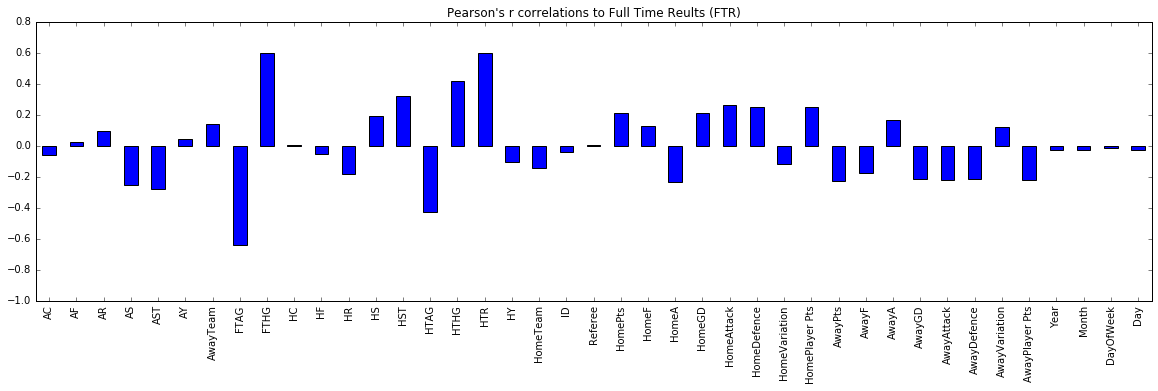

In [11]:
# Here we create an array of correlations between each feature in X, and y (the FTR data).
pears_r = []
for columns in X:
    inData = sp.stats.pearsonr(X[columns], y)
    pears_r.append(inData[0])

# Draw a bar chart to visualise the correlations
pears_df = pd.Series(pears_r, index = X.columns)
pears_df.plot.bar(figsize=(20,5), 
                  yticks=np.arange(-1,1, 0.2), 
                  title = "Pearson's r correlations to Full Time Reults (FTR)")

(2) Another way to visualise the correlations is feature by feature. This can be shown in a correlation matrix. To compare the features against FTR, we can look at the FTR column and see the colours of each corresponding feature. This reflects what we see in the Pearson's _r_ table, like the Referee being very low showing a green colour in the correlation matrix.

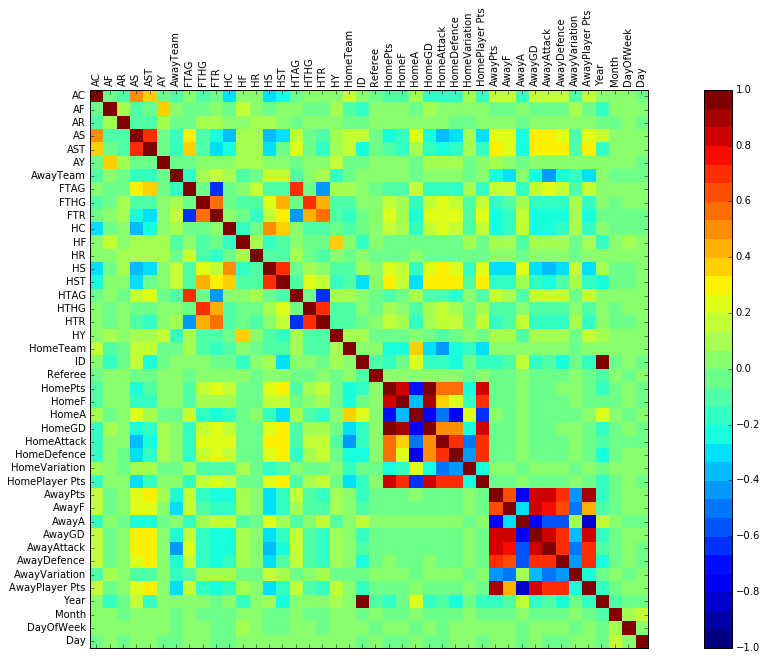

In [12]:
correlations = data_train.corr()

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
cmap = cm.get_cmap('jet', 30)
cax = ax.matshow(correlations, interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.grid(False)

fig.colorbar(cax)
ticks = np.arange(len(data_train.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data_train.columns)
ax.set_yticklabels(data_train.columns)
plt.show()

(3) Even if both Pearson's _r_ and the correlation matrix gives us an idea of how much a feature is related to the target value, the feature might have an indirect contribution. To test recursively whether some features have a relationship with FTR we can perform feature selection to get rankings of the importance of the features. The main reasons of doing feature selection are as follows:

1. **Reduces Overfitting:** Less redundant data means less opportunity to make decisions based on noise.
2. **Improves Accuracy:** Less misleading data means modeling accuracy improves.
3. **Reduces Training Time:** Less data means that algorithms train faster.

The models that are being trained for feature selection is:
- Stability (Randomized Lasso)
- RFE (Recursive Feature Extraction)
- Feature Importance (Extra Trees Classifier)

,Feature Importance,RFE,Stability
HTAG,0.15,1.00,0.06
FTHG,0.94,1.00,1.00
HTR,0.77,1.00,1.00
HTHG,0.24,1.00,0.00
FTAG,1.00,1.00,1.00
HST,0.18,0.97,0.08
AwayPts,0.04,0.94,0.01
...,...,...,...
HomeVariation,0.00,0.17,0.04
HF,0.09,0.14,0.06


None

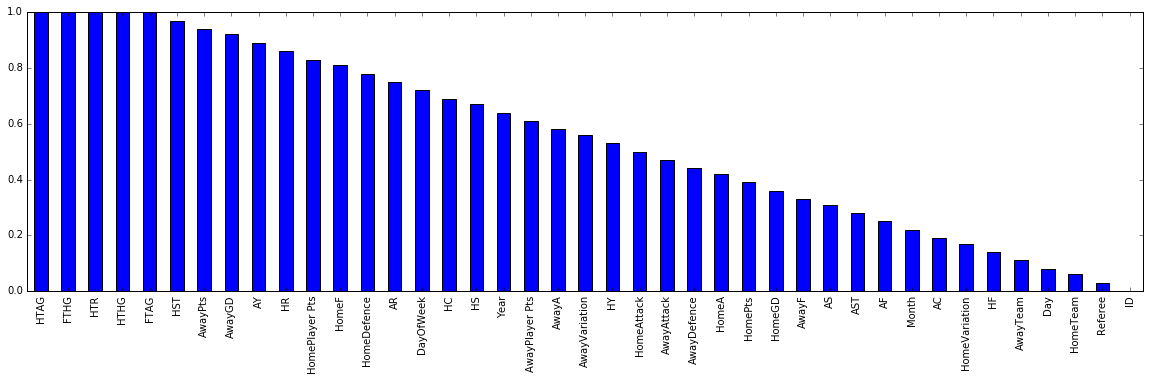

In [13]:
names = X.columns
ranks = {}
 
def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks ))

# Find stability of feature
def stability(ranks, name):
    rlasso = RandomizedLasso(alpha = 0.0005)
    rlasso.fit(X, y)
    ranks[name] = rank_to_dict(np.abs(rlasso.scores_), names)

# Find the RFE of feature and find top 5 features
def rfe(ranks, name):
    lr = LogisticRegression()
    rfe = RFE(lr, n_features_to_select=5)
    rfe.fit(X, y)
    ranks[name] = rank_to_dict(map(float, rfe.ranking_), names, order=-1)

# Find the importance of the feature
def feat_imp(ranks, name):
    forest = ExtraTreesClassifier()
    forest.fit(X, y)
    ranks[name] = rank_to_dict(map(float, forest.feature_importances_), names)

stability(ranks, "Stability")
rfe(ranks, "RFE")
feat_imp(ranks, "Feature Importance")

f, pval  = f_regression(X, y, center=True)
ranks = pd.DataFrame(ranks)
ranks = ranks.sort_values(['RFE'], ascending = False)

display(ranks, pd.set_option('display.max_rows', 15))

# Draw graph showing the Randomized Lasso 
ranks['RFE'].plot(kind='bar', figsize=(20,5))

The table above is sorted by RFE, since this is the method that is most relevant to this type of task. RFE is a feature selection approach that works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target value. We can also see that both Feature Importance and Stability is supporting the RFE by having values in the same "area". By comparing this table to the other table using Pearson's _r_, it shows that it is not sufficient to use only Pearson's _r_ to get accurate ratings of the features.

Since some features are more important than others, a threshold of .15 must be passed in order to be used for training.

In [14]:
# Remove all irrelevant features
new_X = X.copy()
new_validation = validation.copy()
new_test = data_test.copy()
for rank in ranks.index:
    if ranks['RFE'][rank] < 0.15:
        new_X.drop(rank, axis=1, inplace=True)
        new_validation.drop(rank, axis=1, inplace=True)
        new_test.drop(rank, axis=1, inplace=True)

# Methodology Overview

1. Training phase (on X_train)
2. Validation phase (on data_validate)
3. Test phase (on X_test)
4. Predict future games

There are many different machine learning models, but only some are relevant for a task of classification. I have used  scikit learn's cheat-sheet[^1] as a guideline of which specific models to use. From background reading, it appeared that many papers that have tackled the problem of classification of historical data. Ahmed, N.K et. al (2007)[^2] used KNN, regression trees, SVC and a Gaussian process. Ulmer, B. and Fernandez, M. (2014)[^3] used Naive Bayes, Hidden Markov Model, Support Vector Machine (SVM), and Random Forest. From the readings I decided to use these four models:

- Support Vector Machines
- Gaussian Naive Bayes
- KNN
- Ada Boost

The reason I use Ada Boost is that it fits a sequence of weak learners (i.e. desicion trees) repeatedly into a combination that makes it very powerful.

Moreover, in order to get accuracte results from the model we need to train it on different types of splits of the dataset. This is called cross validation (CV), where I use k-fold CV to split into k smaller sets. Using cross validation, we are able to objectively compare the models in terms of their respective fractions of misclassifications. With the CV we can compute both CV accuracy score and the ROC area under curve (AUC) to get an idea of which model performs better. This is validated by:

1. Comparing the results to the bookies
2. Comparing the results to the actual true value

By comparing the results, the best model will be picked to study more in depth. The final model can now being trained and further details about accuracy thrugh a confusion matrix is provided. Finally, we can train the model on the full dataset and predict the new outcoming games in the future.


[^1]: <http://scikit-learn.org/stable/tutorial/machine_learning_map/>
[^2]: <http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=0A60538A2F4443F0E7EC9E96B54E88A6?doi=10.1.1.114.8923&rep=rep1&type=pdf>
[^3]: <http://cs229.stanford.edu/proj2014/Ben%20Ulmer,%20Matt%20Fernandez,%20Predicting%20Soccer%20Results%20in%20the%20English%20Premier%20League.pdf>



### Model Training and Validation

Before doing the cross validation tests on the four classifiers, we need a validation and test set to compare the values with. 

In [15]:
data_validate = data_validate[["FTR"]]
data_validate = data_validate.dropna()
data_validate = data_validate.apply(lambda x: d[x.name].transform(x))

val_bin = label_binarize(data_validate, classes=[1,2,3])
y_bin = label_binarize(y, classes=[1,2,3])

We create a results table to show how well each model performed.

In [16]:
results = pd.DataFrame(columns=['Model', 'Accuracy', 'AUC_y', 'AUC_bookies'])

Below, the four models are being cross validated and a accuracy score and AUC is calculated against both the bookies and the true value.

In [17]:
# Supper Vector Classifier
svc = SVC(kernel='linear', C=1, probability=True)
svc_proba = cross_val_predict(svc, new_validation, y, cv=KFold(3), method='predict_proba')
svc_score = cross_val_score(svc, new_validation, y, cv=3)
svc_auc_y = metrics.roc_auc_score(y_bin, svc_proba)
svc_auc_val = metrics.roc_auc_score(val_bin, svc_proba)

results = results.append(pd.DataFrame({"Model": "SVC", "Accuracy": svc_score.mean(),"AUC_y": svc_auc_y, "AUC_bookies": svc_auc_val}, index=[0]))

In [18]:
# Gaussian Naive Bayes Model
gnb = GaussianNB()
gnb_proba = cross_val_predict(gnb, new_validation, y, cv=KFold(n_splits = 3), method='predict_proba')
gnb_score = cross_val_score(gnb, new_validation, y, cv=3)
gnb_auc_y = metrics.roc_auc_score(y_bin, gnb_proba)
gnb_auc_val = metrics.roc_auc_score(val_bin, gnb_proba)

results = results.append(pd.DataFrame({"Model": "GNB", "Accuracy": gnb_score.mean(),"AUC_y": gnb_auc_y, "AUC_bookies": gnb_auc_val}, index=[0]))

In [19]:
# In the KNN classifier we train on different neighbour values to get the n with the highest performance rate
knn_auc = 0
best_n = 0
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn_proba = cross_val_predict(knn, new_validation, y, cv = KFold(n_splits = 3), method = 'predict_proba')
    if(metrics.roc_auc_score(y_bin, knn_proba) > knn_auc):
        knn_auc = metrics.roc_auc_score(y_bin, knn_proba)
        best_n = i

knn = KNeighborsClassifier(n_neighbors=best_n)
knn_proba = cross_val_predict(knn, new_validation, y, cv = KFold(n_splits = 3), method = 'predict_proba')
knn_score = cross_val_score(knn, new_validation, y, cv=3)
knn_auc_y = metrics.roc_auc_score(y_bin, knn_proba)
knn_auc_val = metrics.roc_auc_score(val_bin, knn_proba)

results = results.append(pd.DataFrame({"Model": "KNN", "Accuracy": knn_score.mean(),"AUC_y": knn_auc_y, "AUC_bookies": knn_auc_val}, index=[0]))

In [20]:
# Ada Boost Classifier
ada = AdaBoostClassifier(n_estimators=100)
ada_proba = cross_val_predict(ada, new_validation, y, cv=KFold(n_splits = 3), method='predict_proba')
ada_score = cross_val_score(ada, new_validation, y, cv=3)
ada_auc_y = metrics.roc_auc_score(y_bin, ada_proba)
ada_auc_val = metrics.roc_auc_score(val_bin, ada_proba)

results = results.append(pd.DataFrame({"Model": "Ada Boost", "Accuracy": ada_score.mean(),"AUC_y": ada_auc_y, "AUC_bookies": ada_auc_val}, index=[0]))

After evaluating the AUC of each classifier through cross validation, we can get an idea of which model performs better. This is shown in a bar chart.

   AUC_bookies     AUC_y  Accuracy      Model
0     0.555768  0.606782  0.494172        SVC
0     0.572814  0.648057  0.516836        GNB
0     0.578956  0.636080  0.507277        KNN
0     0.567484  0.613627  0.424155  Ada Boost


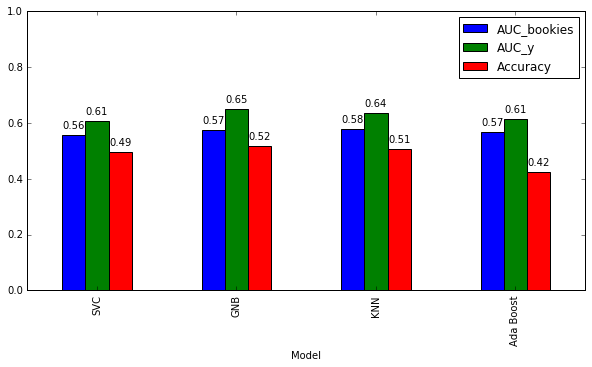

In [21]:
# results.set_index('Model', inplace=True)
print results
ax = results.ix[0].plot(x="Model", kind='bar', figsize=(10,5)); plt.axhline(1, color='k')

for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

We can see that the Gaussian Naive Bayes (GNB) and KNN performed best out of the four classifiers, but that overall, GNB performed best. Hence, we will stick with the GNB to train the data on.

## Results
We will now use the normal way of splitting the training data to evaluate the performance of the GNB classifier. We will fit it with the training set `X_train` and `y_train` followed by presenting the accuracy score

In [22]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.4, random_state=0)

label_bin = label_binarize(y_test, classes=[1,2,3])
gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_pred = gnb.predict(X_test)
gnb_acc = metrics.accuracy_score(y_test, gnb_pred)
print "Model accuracy: %.3f" % gnb_acc

gnb_prob = gnb.predict_proba(X_test)
gnb_auc = metrics.roc_auc_score(label_bin, gnb_prob)
print "AUC score: %.3f\n" %gnb_auc

print metrics.classification_report(y_test, gnb_pred)

Model accuracy: 0.687
AUC score: 0.848

             precision    recall  f1-score   support

          1       0.65      0.76      0.70       230
          2       0.50      0.45      0.47       212
          3       0.82      0.78      0.80       353

avg / total       0.69      0.69      0.68       795



By using a normal split of the training set rather than cross validation, we get an expected higher accuracy score. We see the classification report and can see that the model is best at classifying class 3 (HomeGoal) and worse at classifying class 2 (Draw).

We can see better the false and true predictions in the confusion matrix below.

Normalized confusion matrix
[[ 0.76  0.22  0.02]
 [ 0.28  0.45  0.27]
 [ 0.09  0.12  0.78]]


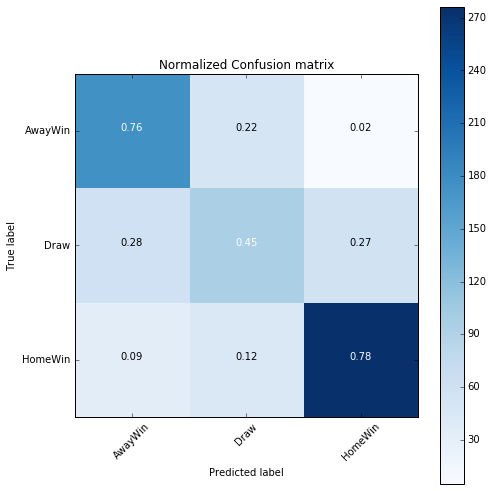

In [23]:
# Confusion Matrix from sklearn's demo
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals = 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix =  metrics.confusion_matrix(y_test, gnb_pred)
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=['AwayWin','Draw', 'HomeWin'], normalize=True, title='Normalized Confusion matrix')
plt.show()

We can see from the confusion matrix that the classifier is better in predicting either a HomeWin or AwayWin but just scores a correct draw 45% of the time. Hence, we can therefore be more sure about the prediction when it classifies it as either Home or Away win. 

## Final Prediction on Test Set
To be able to predict the future games, we train on the full dataset to get as accurate results as possible. We then append the results to a table, which is shown below.

In [24]:
gnb.fit(new_X, y)
gnb_pred = gnb.predict(new_test)
dtest = data_test.copy()
dtest = dtest.reset_index()
dtest['FTR'] = gnb_pred
dtest = dtest[['HomeTeam', 'AwayTeam', 'FTR']].apply(lambda x: d[x.name].inverse_transform(x))
date_extraction = pd.read_csv('data/epl-test.csv')
dtest['Date'] = date_extraction['Date']
display(dtest[['Date', 'HomeTeam', 'AwayTeam', 'FTR']])

,Date,HomeTeam,AwayTeam,FTR
0,21/01/2017,Man City,Tottenham,D
1,21/01/2017,Liverpool,Swansea,H
2,21/01/2017,Middlesbrough,West Ham,A
3,21/01/2017,West Brom,Sunderland,D
4,21/01/2017,Crystal Palace,Everton,A
5,21/01/2017,Stoke,Man United,A
6,21/01/2017,Bournemouth,Watford,D
7,22/01/2017,Arsenal,Burnley,H
8,22/01/2017,Chelsea,Hull,H
9,22/01/2017,Southampton,Leicester,A


Given all the prior probabilities, the table above are the predicted results of the future 10 games. 